# COCO Instance Segmentation

COCO is a large image dataset designed for object detection, segmentation, person keypoints detection, stuff segmentation, and caption generation. We will focus on instance segmentation, i.e. distinguishing each category, giving different labels for individual instances in the same type of objects. It can be regarded as delivering the tasks of object detection and semantic segmentation at the same time. We will be using GPU of Hyperion server of City, University of London. Data is pre-downloaded from https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset to Hyperion under directory '/mnt/data/public/coco2017'. Data original source: https://cocodataset.org/

In [1]:
!pip install pycocotools
from pycocotools.coco import COCO
import cython
from torch.utils import data
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch, torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.ops.boxes import box_convert

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')

print(device)

cuda


## Check Dataset File Structure

In [2]:
path = '/mnt/data/public/coco2017/coco2017'

files = os.listdir(path)

for f in files:
	print(f)

annotations
test2017
train2017
val2017


In [3]:
path_a = path + '/annotations'

files = os.listdir(path_a)

for f in files:
	print(f)

person_keypoints_val2017.json
instances_val2017.json
person_keypoints_train2017.json
instances_train2017.json
captions_val2017.json
captions_train2017.json


## Check Categories

In [4]:
dataDir='/mnt/data/public/coco2017/coco2017/annotations'
dataType='val'
annFile='{}/instances_{}2017.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
coco_val=COCO(annFile)

# Load the categories in a variable
catIDs = coco_val.getCatIds()
cats = coco_val.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'n

In [5]:
annotations_file='/mnt/data/public/coco2017/coco2017/annotations/instances_train2017.json' #file of coco dataset annotations 

# Initialize the COCO api for instance annotations
coco_train=COCO(annotations_file)

# Load the categories in a variable
catIDs = coco_train.getCatIds()
cats = coco_train.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=12.81s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, '

We can see that the category id of person is 1.

# Mask R-CNN
The code for mask R-CNN uses torchvision model, and is largely based on official tutorial from pytorch.org on finetuning mask R-CNN, with customization to the server environment (i.e. its absence of direct access to Internet) and our use case.

Reference:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html and Lecture notes, INM705 DEEP LEARNING FOR IMAGE ANALYSIS - Lab5 by Dr Alex Ter-Sarkisov@City, University of London

From https://github.com/pytorch/vision.git, pre-download engine.py, utlis.py, transform.py (and they depend on coco_eval.py, coco_utlis.py, so they also need to be downloaded)

Let's see one of the images.

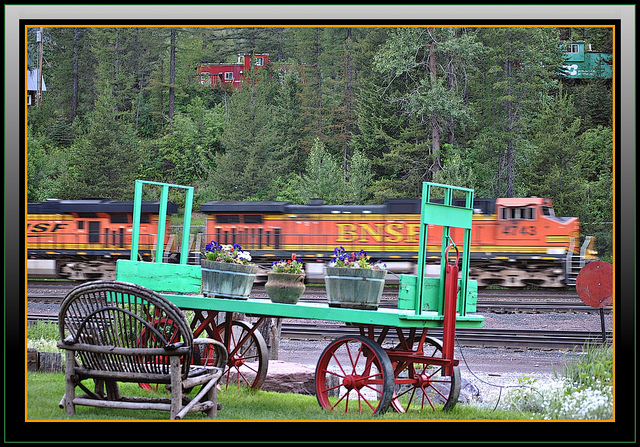

In [6]:
from PIL import Image
Image.open(path+'/test2017/000000112691.jpg')

# Finetuning from a pretrained model

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO; need to download weights manually beforehand as Hyperion is not connected to internet directly
# Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
# Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth"
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False,)
pretrained_weights = torch.load('fasterrcnn_resnet50_fpn_coco-258fb6c6.pth', map_location='cpu')
# # copy only backbone weights
for _n, _par in model.state_dict().items():
     if 'backbone' in _n:
        _par.requires_grad = False
        _par.copy_(pretrained_weights[_n])
        _par.requires_grad = True

if device == torch.device('cuda'):
    model = model.to(device)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

## Helper function

In [8]:
#import python modules downloaded from pytorch github https://github.com/pytorch/vision/tree/main/references/detection  
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## Define CocoDataset

While there are online examples of dataset codes, we need to customize to our needs by setting category to focus, excluding crowd for better data quality, and cleaning the data by removing those without mask annotations.

One note on the labels. The model considers class 0 as background. So we should avoid labeling any class as 0 if we don't have background. As we only focus on person category which has ID 1, we simply label it as 1.

Lets's explore the annotations and data structure a bit before creating the dataset.

In [9]:
AnnIds = coco_train.getAnnIds(catIds=[1], areaRng=[], iscrowd=False)
anns_obj1 = coco_train.loadAnns(AnnIds)
print(anns_obj1[0])
anns_obj2 = [ann for ann in anns_obj1 if len(coco_train.annToMask(ann)) > 0]  #remove empty mask
print(anns_obj2[0])

{'segmentation': [[267.03, 243.78, 314.59, 154.05, 357.84, 136.76, 374.05, 104.32, 410.81, 110.81, 429.19, 131.35, 420.54, 165.95, 451.89, 209.19, 464.86, 240.54, 480.0, 253.51, 484.32, 263.24, 496.22, 271.89, 484.32, 278.38, 438.92, 257.84, 401.08, 216.76, 370.81, 247.03, 414.05, 277.3, 433.51, 304.32, 443.24, 323.78, 400.0, 362.7, 376.22, 375.68, 400.0, 418.92, 394.59, 424.32, 337.3, 382.16, 337.3, 371.35, 388.11, 327.03, 341.62, 301.08, 311.35, 276.22, 304.86, 263.24, 294.05, 249.19]], 'area': 28292.086249999993, 'iscrowd': 0, 'image_id': 537548, 'bbox': [267.03, 104.32, 229.19, 320.0], 'category_id': 1, 'id': 183020}
{'segmentation': [[267.03, 243.78, 314.59, 154.05, 357.84, 136.76, 374.05, 104.32, 410.81, 110.81, 429.19, 131.35, 420.54, 165.95, 451.89, 209.19, 464.86, 240.54, 480.0, 253.51, 484.32, 263.24, 496.22, 271.89, 484.32, 278.38, 438.92, 257.84, 401.08, 216.76, 370.81, 247.03, 414.05, 277.3, 433.51, 304.32, 443.24, 323.78, 400.0, 362.7, 376.22, 375.68, 400.0, 418.92, 394.5

In [10]:
len(anns_obj1)

257253

In [11]:
len(anns_obj2)

257253

It shows that it does not have empty mask for non-crowd person category. Let's see the annotations and image object.

In [12]:
print(coco_train.annToMask(anns_obj1[0]))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
image_id = anns_obj1[0]['id']
img_obj = coco_train.loadImgs(image_id)[0]
print(img_obj['file_name'])

000000183020.jpg


In [14]:
img_obj

{'license': 6,
 'file_name': '000000183020.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000183020.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-18 04:17:41',
 'flickr_url': 'http://farm5.staticflickr.com/4024/4410603312_2729198c47_z.jpg',
 'id': 183020}

Let's deine COCO dataset class for dataloader of the model.

In [15]:
#inspired and adapt from reference below, with customization and correction
#reference: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
           #https://stackoverflow.com/questions/68513782/use-ms-coco-format-as-input-to-pytorch-maskrcnn
           #Lecture notes, INM705 DEEP LEARNING FOR IMAGE ANALYSIS - Lab5 by Dr. Alex Ter-Sarkisov @ City, University of London

dataset_dir='/mnt/data/public/coco2017/coco2017'
focus_category = [1]   #1: person category

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, subset='train', transforms=None, focus_category=focus_category, areaRng=[], iscrowd=False):
        ann_file = '{}/annotations/instances_{}2017.json'.format(dataset_dir, subset)
        self.imgs_dir = os.path.join(dataset_dir, subset+'2017')
        self.coco = COCO(ann_file)
        AnnIds = self.coco.getAnnIds(catIds=focus_category, areaRng=areaRng, iscrowd=iscrowd)
        self.anns_obj = self.coco.loadAnns(AnnIds)
        self.transforms = transforms
        self.focus_category = focus_category
        self.areaRng = areaRng
        
    def __len__(self):
        self.length = len(self.anns_obj)
        return self.length  

    def mabi(self, ann, masks, areas, boxes, image_id):
        masks.append(self.coco.annToMask(ann))
        areas.append(ann['area'])
        boxes.append([ann['bbox'][0], ann['bbox'][1], ann['bbox'][0]+ann['bbox'][2], ann['bbox'][1]+ann['bbox'][3]])
        image_id.append(ann['image_id'])
        return masks, areas, boxes, image_id
    
    def __getitem__(self, idx):
        '''
        Args:
            idx: index of sample to be fed
        return:
            dict containing:
            - PIL Image of shape (H, W)
            - target (dict) containing: 
                - boxes:    FloatTensor[N, 4], N being the n° of instances and it's bounding 
                boxe coordinates in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H;
                - labels:   Int64Tensor[N], class label (0 is background);
                - image_id: Int64Tensor[1], unique id for each image;
                - area:     Tensor[N], area of bbox;
                - iscrowd:  UInt8Tensor[N], True or False;
                - masks:    UInt8Tensor[N, H, W], segmantation maps;
        '''
  
        anns = self.anns_obj[idx] 
        
        # fix old format issue: convert [xmin, ymin, width, height] in pycocotools to [xmin, ymin, xmax, ymax] format required by model
        boxes=[]
        masks=[]
        areas=[]
        image_id=[]
        if isinstance(idx, int):
            masks, areas, boxes, image_id = self.mabi(anns, masks, areas, boxes, image_id)
        elif len(idx) == 1:
            masks, areas, boxes, image_id = self.mabi(anns, masks, areas, boxes, image_id)
        else:
            for ann in anns: 
                masks, areas, boxes, image_id = self.mabi(ann, masks, areas, boxes, image_id)
        
        image_id = np.array(image_id)
        
        img_obj = self.coco.loadImgs(image_id)[0]
        img = Image.open(os.path.join(self.imgs_dir, img_obj['file_name']))
        if self.transforms is not None:
            img = self.transforms(img)
        
        
        labels = torch.ones(self.length, dtype=torch.int64)   #set label as 1, because we only focus on one class and 0 is reserved for background
        iscrowd = torch.zeros(self.length, dtype=torch.int64) #because we have excluded crowd
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)  #empty box causes error, reshape from 0 to (0,4) for empty box
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor(image_id)
        area = torch.as_tensor(areas)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target


In [16]:
anns_obj = COCO(annFile).loadAnns(COCO(annFile).getAnnIds(COCO(annFile).getImgIds(536))) 

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=2.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


# Instance segmentation model

In [17]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False,  pretrained_backbone=False,)
    pretrained_weights = torch.load('maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth', map_location='cpu')
    # # copy only backbone weights
    for _n, _par in model.state_dict().items():
         if 'backbone' in _n:
            _par.requires_grad = False
            _par.copy_(pretrained_weights[_n])
            _par.requires_grad = True

    if device == torch.device('cuda'):
        model = model.to(device)
    
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## Putting everything together

In [18]:
# use our dataset and defined transformations
import torchvision.transforms as transforms
dataset = CocoDataset('/mnt/data/public/coco2017/coco2017', 'train', transforms.Compose([transforms.ToTensor()]))
dataset_test = CocoDataset('/mnt/data/public/coco2017/coco2017', 'val', transforms.Compose([transforms.ToTensor()]))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=11.47s)
creating index...
index created!
loading annotations into memory...
Done (t=5.35s)
creating index...
index created!


In [19]:
dataset.__getitem__(536)[0]

/tmp/ipykernel_245359/1899240469.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


tensor([[[0.9961, 0.9961, 0.9922,  ..., 0.9843, 0.9882, 0.9961],
         [0.9961, 0.9922, 0.9961,  ..., 0.9804, 0.9882, 1.0000],
         [0.9961, 0.9922, 0.9961,  ..., 0.9804, 0.9882, 0.9922],
         ...,
         [0.9922, 0.9922, 0.9843,  ..., 0.9843, 0.9961, 0.9843],
         [0.9922, 0.9843, 0.9765,  ..., 0.9804, 0.9725, 0.9922],
         [0.9843, 0.9804, 0.9843,  ..., 0.9725, 0.9882, 0.9922]],

        [[0.9961, 0.9961, 0.9922,  ..., 0.9843, 0.9882, 0.9961],
         [0.9961, 0.9922, 0.9961,  ..., 0.9804, 0.9882, 1.0000],
         [0.9961, 0.9922, 0.9961,  ..., 0.9804, 0.9882, 0.9922],
         ...,
         [0.9922, 0.9922, 0.9843,  ..., 0.9843, 0.9961, 0.9843],
         [0.9922, 0.9843, 0.9765,  ..., 0.9804, 0.9725, 0.9922],
         [0.9843, 0.9804, 0.9843,  ..., 0.9725, 0.9882, 0.9922]],

        [[0.9961, 0.9961, 0.9922,  ..., 0.9843, 0.9882, 0.9961],
         [0.9961, 0.9922, 0.9961,  ..., 0.9804, 0.9882, 1.0000],
         [0.9961, 0.9922, 0.9961,  ..., 0.9804, 0.9882, 0.

## Instantiate the model and optimizer

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

## Training

In [ ]:
# let's train it for 2 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 1000 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1000)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [     0/128602]  eta: 3 days, 2:28:44  lr: 0.000010  loss: 3.5788 (3.5788)  loss_classifier: 0.6955 (0.6955)  loss_box_reg: 0.0058 (0.0058)  loss_mask: 2.1773 (2.1773)  loss_objectness: 0.6862 (0.6862)  loss_rpn_box_reg: 0.0140 (0.0140)  time: 2.0849  data: 0.7402  max mem: 2476
Epoch: [0]  [    10/128602]  eta: 12:26:13  lr: 0.000060  loss: 3.3036 (3.2665)  loss_classifier: 0.6708 (0.6690)  loss_box_reg: 0.0002 (0.0037)  loss_mask: 1.9324 (1.8980)  loss_objectness: 0.6840 (0.6834)  loss_rpn_box_reg: 0.0045 (0.0125)  time: 0.3482  data: 0.0922  max mem: 4283
Epoch: [0]  [    20/128602]  eta: 9:33:27  lr: 0.000110  loss: 2.8129 (2.9641)  loss_classifier: 0.5943 (0.5899)  loss_box_reg: 0.0002 (0.0029)  loss_mask: 1.5349 (1.6791)  loss_objectness: 0.6798 (0.6791)  loss_rpn_box_reg: 0.0045 (0.0131)  time: 0.1767  data: 0.0290  max mem: 4283
Epoch: [0]  [    30/128602]  eta: 8:26:59  lr: 0.000160  loss: 2.1910 (2.6668)  loss_classifier: 0.3999 (0.5003)  loss_box_reg: 0.0003 (0.0

## Prediction

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
    
prediction

Convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in [C, H, W] format.

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

Let's now visualize the top predicted segmentation mask. The masks are predicted as [N, 1, H, W], where N is the number of predictions, and are probability maps between 0-1.

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())